In [1]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
import random
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import scipy as spy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
import numpy
from scipy.io import savemat,loadmat
import os
from sklearn.neural_network import MLPRegressor 

In [2]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
dataset = pd.read_excel("816480.xlsx")
fratures_Corrected_irradiance = [
    'Flow (Veh/5 Minutes)'
]
values = dataset[fratures_Corrected_irradiance].values
n_features=1 #特征数量

In [4]:
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(values)

In [5]:
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values

In [6]:
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

# 划分输入和输出,split into input and outputs
n_obs = n_in * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1149, 3) (1149,) (288, 3) (288,)


In [7]:
train_y=train_y.reshape(len(train_y))
train_y.shape

(1149,)

In [8]:
bp = MLPRegressor(hidden_layer_sizes=(20),  max_iter=20, random_state=10,verbose=2)  # BP神经网络回归模型
model=bp.fit(train_X,train_y)  # 训练模型

Iteration 1, loss = 0.82926432
Iteration 2, loss = 0.76166286
Iteration 3, loss = 0.69621762
Iteration 4, loss = 0.63356931
Iteration 5, loss = 0.57516512
Iteration 6, loss = 0.51895476
Iteration 7, loss = 0.46648049
Iteration 8, loss = 0.41563444
Iteration 9, loss = 0.36841791
Iteration 10, loss = 0.32151058
Iteration 11, loss = 0.27818793
Iteration 12, loss = 0.23864013
Iteration 13, loss = 0.20192555
Iteration 14, loss = 0.16894158
Iteration 15, loss = 0.13962009
Iteration 16, loss = 0.11449301
Iteration 17, loss = 0.09326940
Iteration 18, loss = 0.07572522
Iteration 19, loss = 0.06128353
Iteration 20, loss = 0.04979829


C:\Application\Anaconda\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
#预测
yhat = model.predict(test_X)
yhat=yhat.reshape(-1,1)
# 对预测结果进行反归一化
inv_yhat = scaler.inverse_transform(yhat)
# 将真实列据进行反归一化
test_y=test_y.reshape(-1,1)
inv_y = scaler.inverse_transform(test_y)

In [10]:
# 计算RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(inv_y, inv_yhat))
print('Test R2: %.7f' % r2_score(inv_y, inv_yhat))

Test RMSE: 49.2312011
Test MAE: 41.7870722
Test R2: 0.9089963


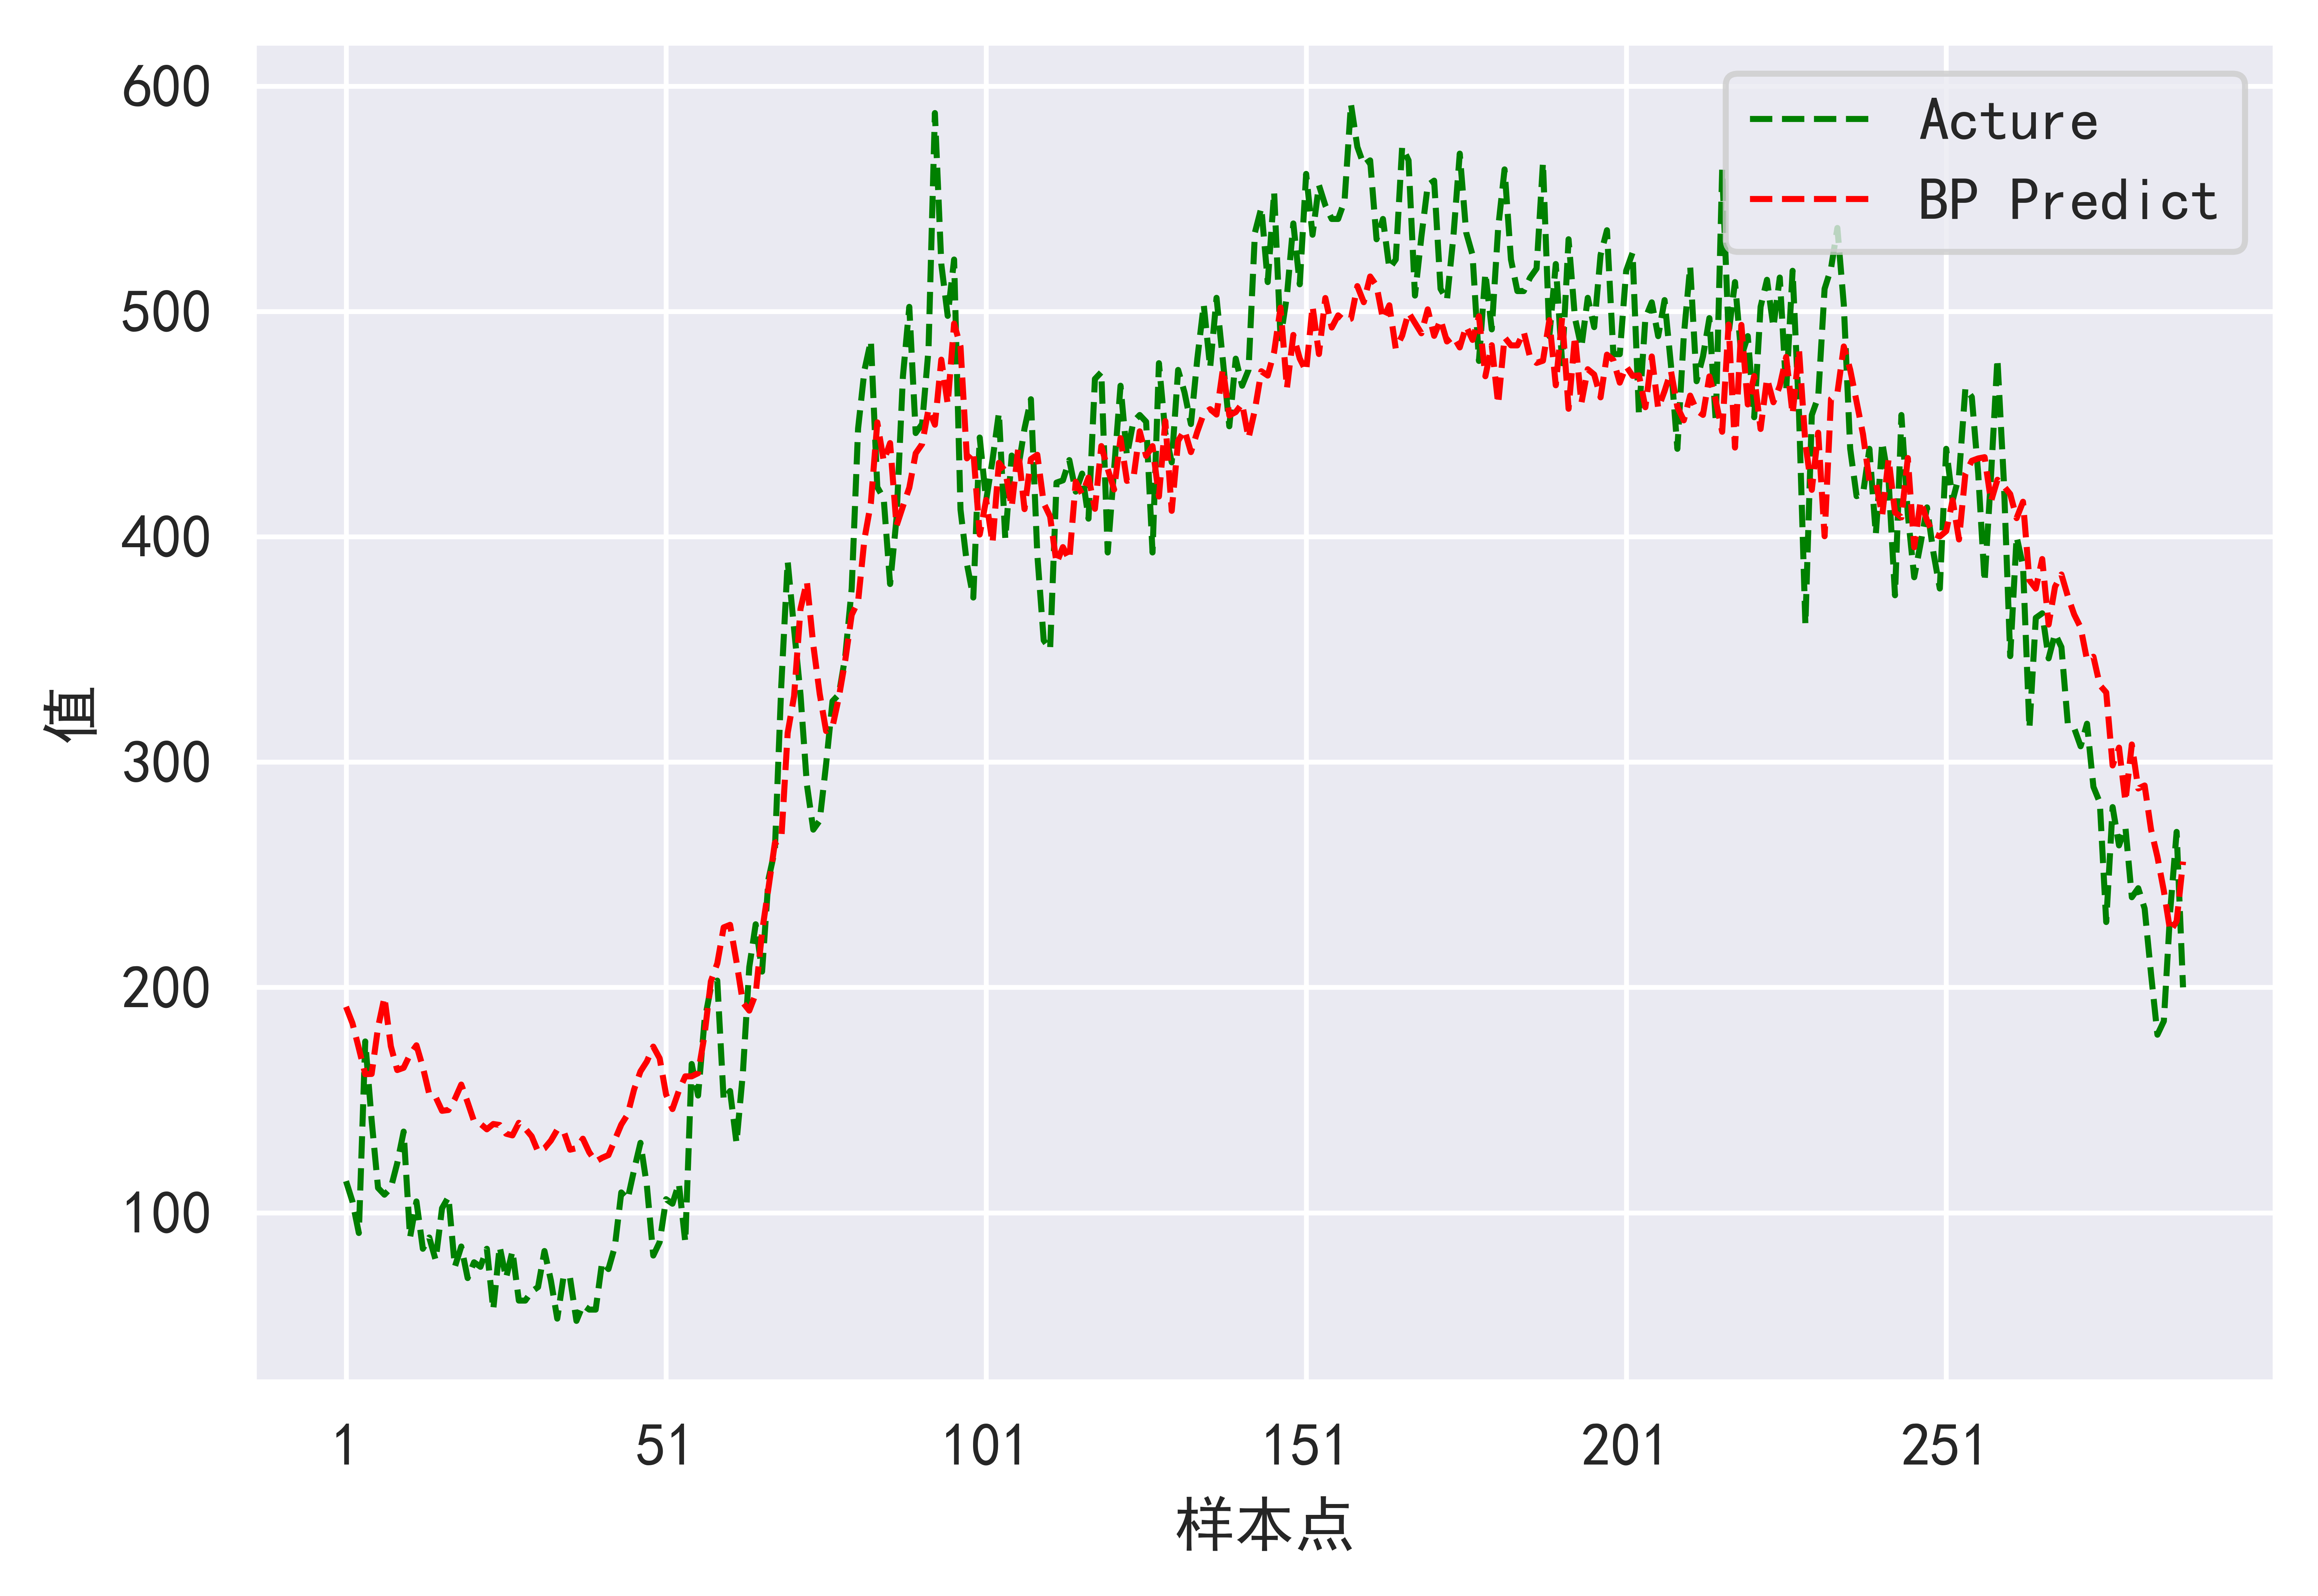

In [11]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(inv_y) + 1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, inv_y, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, inv_yhat,  color='red',linestyle="--",linewidth=1,label='BP Predict')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('figure/BP预测结果图.png')
plt.show()

In [12]:
#保存预测结果
savemat('结果/bp2_result.mat',{'true':inv_y,'pred':inv_yhat})